In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.model_selection import GridSearchCV

/var/folders/5r/8jpxvt3s2m1cz_nm5k_xb8tm0000gn/T/ipykernel_16211/1915520266.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/polashbaidya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load the scraped stock data into a pandas DataFrame
df = pd.read_csv('Amazon_data.csv')

# Check for missing values
print(df.isnull().sum())  # Count the number of missing values in each column
df.head()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


,date,open,high,low,close,volume
0,2010-01-04,136.25,136.610,133.14,133.90,7599900.0
1,2010-01-05,133.43,135.479,131.81,134.69,8851900.0
2,2010-01-06,134.60,134.730,131.65,132.25,7178800.0
3,2010-01-07,132.01,132.320,128.80,130.00,11030200.0
4,2010-01-08,130.56,133.680,129.03,133.52,9830500.0


In [3]:
df["date"]=pd.to_datetime(df.date)
df.set_index('date', inplace=True)

In [4]:
df

,open,high,low,close,volume
date,,,,,
2010-01-04,136.25,136.610,133.1400,133.90,7599900.0
2010-01-05,133.43,135.479,131.8100,134.69,8851900.0
2010-01-06,134.60,134.730,131.6500,132.25,7178800.0
2010-01-07,132.01,132.320,128.8000,130.00,11030200.0
2010-01-08,130.56,133.680,129.0300,133.52,9830500.0
...,...,...,...,...,...
2022-12-23,83.25,85.780,82.9344,85.25,57433655.0
2022-12-27,84.97,85.350,83.0000,83.04,57284035.0
2022-12-28,82.80,83.480,81.6900,81.82,58228575.0


In [5]:
df['update_open'] = df['open'].shift(1)
df['update_high'] = df['high'].shift(1)
df['update_low'] = df['low'].shift(1)
df['update_close'] = df['close'].shift(1)
df['update_volume'] = df['volume'].shift(1)
print(df)

              open     high       low   close      volume  update_open  \
date                                                                     
2010-01-04  136.25  136.610  133.1400  133.90   7599900.0          NaN   
2010-01-05  133.43  135.479  131.8100  134.69   8851900.0       136.25   
2010-01-06  134.60  134.730  131.6500  132.25   7178800.0       133.43   
2010-01-07  132.01  132.320  128.8000  130.00  11030200.0       134.60   
2010-01-08  130.56  133.680  129.0300  133.52   9830500.0       132.01   
...            ...      ...       ...     ...         ...          ...   
2022-12-23   83.25   85.780   82.9344   85.25  57433655.0        85.52   
2022-12-27   84.97   85.350   83.0000   83.04  57284035.0        83.25   
2022-12-28   82.80   83.480   81.6900   81.82  58228575.0        84.97   
2022-12-29   82.87   84.550   82.5500   84.18  54995895.0        82.80   
2022-12-30   83.12   84.050   82.4700   84.00  62401194.0        82.87   

            update_high  update_low  

In [6]:
df.head()

,open,high,low,close,volume,update_open,update_high,update_low,update_close,update_volume
date,,,,,,,,,,
2010-01-04,136.25,136.610,133.14,133.90,7599900.0,NaN,NaN,NaN,NaN,NaN
2010-01-05,133.43,135.479,131.81,134.69,8851900.0,136.25,136.610,133.14,133.90,7599900.0
2010-01-06,134.60,134.730,131.65,132.25,7178800.0,133.43,135.479,131.81,134.69,8851900.0
2010-01-07,132.01,132.320,128.80,130.00,11030200.0,134.60,134.730,131.65,132.25,7178800.0
2010-01-08,130.56,133.680,129.03,133.52,9830500.0,132.01,132.320,128.80,130.00,11030200.0


In [7]:
df.update_close.fillna(df.close.iloc[1:3].mean(), inplace=True)
df.update_high.fillna(df.high.iloc[1:3].mean(), inplace=True)
df.update_low.fillna(df.low.iloc[1:3].mean(), inplace=True)
df.update_open.fillna(df.open.iloc[1:3].mean(), inplace=True)
df.update_volume.fillna(df.volume.iloc[1:8].mean(), inplace=True)

/var/folders/5r/8jpxvt3s2m1cz_nm5k_xb8tm0000gn/T/ipykernel_16211/109213357.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.update_close.fillna(df.close.iloc[1:3].mean(), inplace=True)
/var/folders/5r/8jpxvt3s2m1cz_nm5k_xb8tm0000gn/T/ipykernel_16211/109213357.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [8]:
df.drop(["open","high","low","volume"],axis=1,inplace=True)

In [9]:
start_date="2010-01-04"
end_date="2020-12-31"
val_start_date="2021-01-04"
val_end_date="2021-12-31"
test_start_date="2022-01-03"
test_end_date="2022-12-30"

train_data=df[start_date:end_date]
val_data=df[val_start_date:val_end_date]
test_data=df[test_start_date:test_end_date]

In [10]:
train_data

,close,update_open,update_high,update_low,update_close,update_volume
date,,,,,,
2010-01-04,133.90,134.015,135.1045,131.730,133.47,9.355757e+06
2010-01-05,134.69,136.250,136.6100,133.140,133.90,7.599900e+06
2010-01-06,132.25,133.430,135.4790,131.810,134.69,8.851900e+06
2010-01-07,130.00,134.600,134.7300,131.650,132.25,7.178800e+06
2010-01-08,133.52,132.010,132.3200,128.800,130.00,1.103020e+07
...,...,...,...,...,...,...
2020-12-24,3172.69,3205.000,3210.1300,3184.170,3185.27,2.093787e+06
2020-12-28,3283.96,3193.900,3202.0000,3169.000,3172.69,1.451917e+06
2020-12-29,3322.00,3194.000,3304.0000,3172.690,3283.96,5.620728e+06


In [11]:
# Normalisation
sc = MinMaxScaler()
train_d = sc.fit_transform(train_data)
val_d = sc.fit_transform(val_data)
test_d=sc.fit_transform(test_data)
print(train_d.shape,val_d.shape,test_d.shape)

(2769, 6) (252, 6) (251, 6)


In [12]:
X, y = train_d[:, 1:], train_d[:, 0]
X_val,y_val=val_d[:, 1:], val_d[:, 0]

In [13]:
print(X.shape,y.shape,X_val.shape,y_val.shape)

(2769, 5) (2769,) (252, 5) (252,)


In [14]:
def predictions(data,model):
    
    predict_value=[]
    for i in range(0,len(data)):
        a=data[i]
        a=a.reshape(1,data.shape[1])
        predict_value.append(model.predict(a))
        try:
            data[:,3][i+1]=predict_value[i][0]
        except:
            pass
    
    predict_value=np.array(predict_value)
    
    prdict_value=predict_value.reshape(predict_value.shape[1],predict_value.shape[0])
    return data,predict_value

In [15]:
X_test,y_test=test_d[:, 1:], test_d[:, 0]
print(X_test.shape,y_test.shape)

(251, 5) (251,)


## Finding Best Hyparameter

In [72]:
# Define parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

# Create XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring=mse_scorer, n_jobs=-1)
grid_search.fit(X, y)  # Assuming X_train and y_train are your training data

# Print best hyperparameters
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test set:", mse)

Best hyperparameters found:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0}
Mean Squared Error on test set: 0.002540615214345723


In [16]:
# Train XGBoost regressor with Random Forest predictions as features
xgb_regressor = xgb.XGBRegressor(colsample_bytree= 0.8, gamma= 0, learning_rate= 0.05, max_depth= 7, min_child_weight= 3,
                                 n_estimators= 200, reg_alpha= 0, reg_lambda= 0, subsample= 1.0)
xgb_regressor.fit(X, y) # we fit the model with updated feature(X) and original target(y) value

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
# Evaluate XGBoost regressor
X_test,y_pred = predictions(X_test,xgb_regressor)

In [43]:
print(y_test.shape,y_pred.shape)

(251,) (251, 1)


In [44]:
print(updated_X_test[:,3][:5],y_pred[:5])

[0.97782802 0.98087656 0.98087656 0.98087656 0.98087656] [[0.98087656]
 [0.98087656]
 [0.98087656]
 [0.98087656]
 [0.98087656]]


In [45]:
predict_value=np.array(y_pred)

predict_value=predict_value.reshape(-1,1)
# predict_value.shape

inv_yhat = np.concatenate((predict_value, test_d[:, 1:]), axis=1)
inv_yhat = sc.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [46]:
inv_train = sc.inverse_transform(train_d)
inv_valid = sc.inverse_transform(val_d)
inv_test = sc.inverse_transform(test_d)
inv_ytrain = inv_train[:,0]
inv_yvalid = inv_valid[:,0]
inv_ytest = inv_test[:,0]

print(inv_ytrain.shape,inv_yvalid.shape,inv_ytest.shape)

(2769,) (252,) (251,)


In [47]:
# Plot the data
train = train_data["close"]
valid = val_data["close"]
test = test_data["close"]
test=test.to_frame()
test["predictions"]=inv_yhat

In [48]:
rmse = sqrt(mean_squared_error(test["close"],test["predictions"]))
mae = mean_absolute_error(test["close"],test["predictions"])
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

RMSE: 189.949
MAE: 69.747


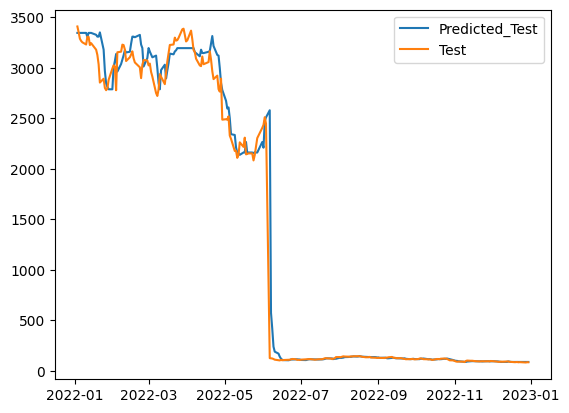

In [49]:
# line plot of observed vs predicted
plt.plot(test["predictions"])
plt.plot(test["close"])
plt.legend(["Predicted_Test","Test"])
plt.show()

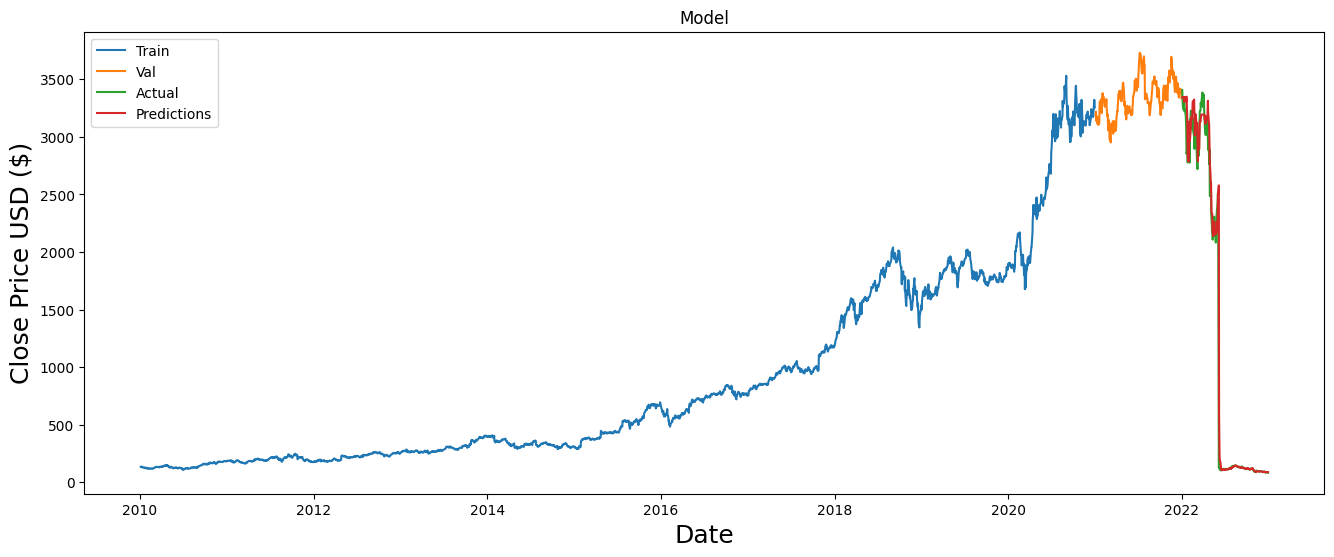

In [36]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train)
plt.plot(valid)
plt.plot(test[['close','predictions']])
plt.legend(['Train', 'Val', 'Actual', 'Predictions'], loc='upper left')
plt.show()

In [50]:
import joblib

joblib.dump(xgb_regressor, 'xgBoost_RMSE: 189.949_MAE: 69.747.joblib')  # Save model to disk

['xgBoost_RMSE: 189.949_MAE: 69.747.joblib']